# This notebook implements the BILP-Q tutorial in Cirq

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq
import cirq_google
from Utils_CSG import *
import sympy 
import numpy as np
from typing import Sequence, Tuple
from cirq.circuits import InsertStrategy
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

## Starting with the a given CSG
Using the same steps as in the BILP-Q Qiskit tutorial to generate the Q-matrix

In [2]:
coalition_values={
    '1':30,
    '2':40,
    '3':25,
    '1,2':70,
    '1,3':60,
    '2,3':65,
    '1,2,3':90
}
coalition_values

{'1': 30, '2': 40, '3': 25, '1,2': 70, '1,3': 60, '2,3': 65, '1,2,3': 90}

In [3]:
c,S,b = convert_to_BILP(coalition_values)       # A function in Utils_CSG.py
print(f'c = {c}\nS = {S}\nb = {b}')

c = [30, 40, 25, 70, 60, 65, 90]
S = [[1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, 1, 1], [0, 0, 1, 0, 1, 1, 1]]
b = [1, 1, 1]


In [4]:
qubo_penalty = 50 * -1

linear,quadratic = get_QUBO_coeffs(c,S,b,qubo_penalty)        # A function in Utils_CSG.py

print(f"Linear Coefficients = {linear} \n Quadratic Coefficients = {quadratic}")

Linear Coefficients = {'x_6': -240.0, 'x_3': -170.0, 'x_4': -160.0, 'x_5': -165.0, 'x_0': -80.0, 'x_1': -90.0, 'x_2': -75.0} 
 Quadratic Coefficients = {('x_3', 'x_6'): 200.0, ('x_4', 'x_6'): 200.0, ('x_5', 'x_6'): 200.0, ('x_0', 'x_3'): 100.0, ('x_0', 'x_4'): 100.0, ('x_0', 'x_6'): 100.0, ('x_1', 'x_3'): 100.0, ('x_1', 'x_5'): 100.0, ('x_1', 'x_6'): 100.0, ('x_2', 'x_4'): 100.0, ('x_2', 'x_5'): 100.0, ('x_2', 'x_6'): 100.0, ('x_3', 'x_4'): 100.0, ('x_3', 'x_5'): 100.0, ('x_4', 'x_5'): 100.0}


In [5]:
Q = np.zeros([len(linear),len(linear)])

#diagonal elements
for key,value in linear.items():
    Q[int(key.split('_')[1]),int(key.split('_')[1])] = value

#non diagonal elements
for key,value in quadratic.items():
    Q[int(key[0].split('_')[1]),int(key[1].split('_')[1])] = value/2
    Q[int(key[1].split('_')[1]),int(key[0].split('_')[1])] = value/2

Q = Q/240
Q.round(4)
#I with "non normalized" values, the circuit will end up in just equal superpositions of a set of qubits"

array([[-0.3333,  0.    ,  0.    ,  0.2083,  0.2083,  0.    ,  0.2083],
       [ 0.    , -0.375 ,  0.    ,  0.2083,  0.    ,  0.2083,  0.2083],
       [ 0.    ,  0.    , -0.3125,  0.    ,  0.2083,  0.2083,  0.2083],
       [ 0.2083,  0.2083,  0.    , -0.7083,  0.2083,  0.2083,  0.4167],
       [ 0.2083,  0.    ,  0.2083,  0.2083, -0.6667,  0.2083,  0.4167],
       [ 0.    ,  0.2083,  0.2083,  0.2083,  0.2083, -0.6875,  0.4167],
       [ 0.2083,  0.2083,  0.2083,  0.4167,  0.4167,  0.4167, -1.    ]])

## Initializing the circuit

There are many other ways to create circuts. Worth mentioning is that cirq can also create grid-circuits and check, whether all two-qubits gates are only applied to adjacent qubits. This can be usefull when implementing for real quantum devices (D-Wave part).

In [6]:
def cirq_init(n_prob):
    """Initializes a circuit of n_prob Line Qubits in equal superposition
    Return: the circuit itself and the quibits used in it"""
    circuit = cirq.Circuit() #initializing a circuit object
    qubits = cirq.LineQubit.range(n_prob) # creating n_prob qubits
    circuit.append(cirq.H(q) for q in qubits) # adding the just created qubits each with a H-Gate to the circuit
    return circuit, qubits

## Creating cost and mixer layers

In [7]:
# the mixer layer should just be a list of X rotation gates with parameter beta on each qubit
# that will be appended to the circuit

def mixer(in_circuit, beta_value: float):
    """Adds a mixer layer to circuit with parameter beta_value"""
    circuit = in_circuit.copy() 
    # without copy() circuit would still be the same instance of in_circuit
    # and mixer() would in-place change in_circuit
    
    n_qubits = len(circuit.get_independent_qubit_sets())
    circuit.append([cirq.X(q) ** beta_value for q in qubits],  strategy=InsertStrategy.NEW_THEN_INLINE)
    # adding an X-gate to the power of beta_value to every qubit. Using an insert strategy to put them all in the same moment
    # for better readability in the diagram later
    return circuit

In [8]:
def cost(in_circuit:cirq.circuits.circuit.Circuit, gamma_value:float, Q:np.ndarray) -> cirq.circuits.circuit.Circuit:
    """Adds the cost layer defined by QUBO matrix Q to circuit with the parameter gamma_value"""
    
    
    circuit = in_circuit.copy()
    nrow = np. size(Q, 0)
    ncol = np. size(Q, 1)
    
    # in the Q matrix, diagonal entries represent the coefficients for linear terms, while the of-diagonal non-zero elements
    # are the coefficients for mixed terms. A linear term will be implemented as Z rotation gate on the resprective qubit,
    # while a mixed term is implemented as ZZ rotational gate on the 2 resprective qubits.
    # the rotations are parametrized by the gamma_value for this sprecific layer
    
    for row in range(nrow):
        # we don't need to iterrate through the whole matrix, since it's symetrical. The upper right part and diagonal is enough
        for col in range(row, ncol):
            
            if row == col:
                lin = Q[row,col]
                continue 
                # if the element is on the diagonal we will collect the coefficient to apply the single Z gate after all
                # ZZ gates are done on this qubit
            
            elif Q[row,col] != 0:
                # when we have a non-diagonal element that is not zero we append a gama_value
                # parametrized ZZ rotation gate on the resprective 2 qubits
                circuit.append(cirq.ZZ(qubits[row],qubits[col]) ** (gamma_value * Q[row,col]))
        # the single qubit z gate for linear terms at the end of all ZZ gate for this qubit 
        if lin != 0:
            circuit.append(cirq.Z(qubits[row]) ** (gamma_value * lin))
                  
    return circuit

## Creating the circuit
Note: the layer-functions still change the circuit in-place

In [9]:
p = 1 # number of layers

# Parameters are introduced as 'symbols'. Symbols can be used like variables in a circuit but need to be 'resolved'
# (get a value assigned to) when we want to simulate or run the circuit
beta = [sympy.Symbol("β_"+str(i)) for i in range(p)]
gamma = [sympy.Symbol("γ_"+str(i)) for i in range(p)]
print(beta, gamma)

[β_0] [γ_0]


In [10]:
problem_size = len(Q[0]) # defines how many qubits will be necessary to represent the problem 

qaoa, qubits = cirq_init(problem_size)

for i in range(p):
    
    qaoa = cost(qaoa, gamma[i], Q)
    
    qaoa = mixer(qaoa, beta[i])

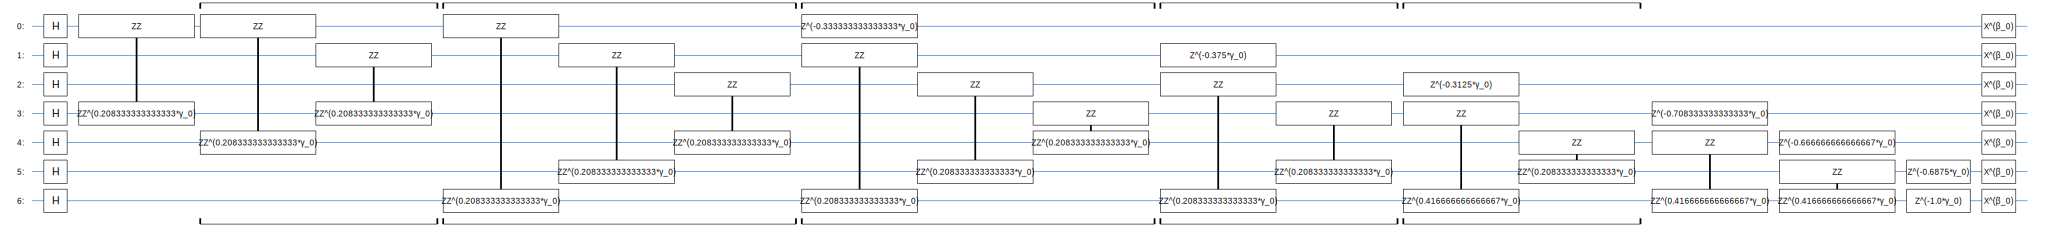

In [11]:
# better printing with SVG
SVGCircuit(qaoa)

In [65]:
def state_vector_params(gamma, beta, circuit):
    simulator = cirq.Simulator() # initializing the simulator object
    params = cirq.ParamResolver({"γ_0": gamma, "β_0": beta}) 
    #the param resolver maps values from the function input to the respective variables in the circuit
    
    result = abs(simulator.simulate(circuit, param_resolver=params).final_state_vector)
    # simulates the final state vector of the circuit with the input values for the parameters gamma and beta
    # only take tha absolut values since the imaginary parts should only exist due to rounding errors
    sum = 0
    for elm in result:
        sum += elm**2
    if 1 != round(sum,3):
        print("Warning: final state vector is normalized. Difference to 1 is more than .001")
    
    return result
 


In [72]:
mat_Z = np.eye(2)
mat_Z[1,1] = -1
M = [1]
for i in range(len(qubits)):
    M = np.kron(M, mat_Z)

shape(M)

(128, 128)

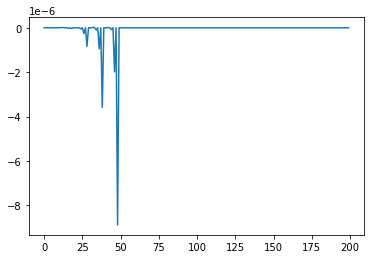

In [101]:
size = 100
energy = np.empty(size*2)
for i in range(0, round(np.sqrt(size)), 2):
    for j in range(0, round(np.sqrt(size)), 2):
        vec = state_vector_params(i/size, j/size, qaoa)
        energy[5*i+j] = vec @ M @ vec

x = np.array(range(size*2))
plt.plot(x,energy)


In [99]:
grid_size = 50
gamma_max = 2
beta_max = 2

# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        vec = state_vector_params(i * gamma_max / grid_size, j * beta_max / grid_size, qaoa)
        energies[i, j] = vec @ M @ vec

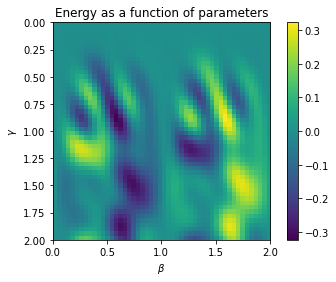

In [100]:
"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()

In [102]:
# Adding a measurement layer
measure_qoao = qaoa.copy()
measure_qoao.append(cirq.measure(qubits, key = 'result'))

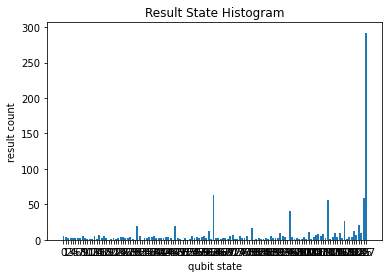

In [103]:
num_reps = 1000
#single instance of parameters
gamma_value, beta_value = 0.5, 0.5 
simulator = cirq.Simulator()
params = cirq.ParamResolver({"γ_0": gamma_value, "β_0": beta_value})
measure_result = simulator.run(measure_qoao, param_resolver=params, repetitions = num_reps)
  
cirq.plot_state_histogram(measure_result, plt.subplot())
plt.show()
